## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
import sys

import IPython.display as ipd
# matplotlib.use('GTK3')
import matplotlib.pylab as plt
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import HParams
from train import load_model
from text import text_to_sequence
# from denoiser import Denoiser
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline


In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
    

#### Setup hparams

In [3]:
hparams = HParams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [4]:
# checkpoint_path = "models/noDisc-iter=45000_val-loss=0.343656.ckpt"
checkpoint_path = "models/iter=50000_val-loss=0.3602.ckpt"

model, _ = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
# denoiser = Denoiser(waveglow)

c:\users\rodri\miniconda3\envs\gantron2\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


#### Prepare text input

In [6]:
text = "Waveglow is really awesome!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

torch.Size([1, 27, 20])


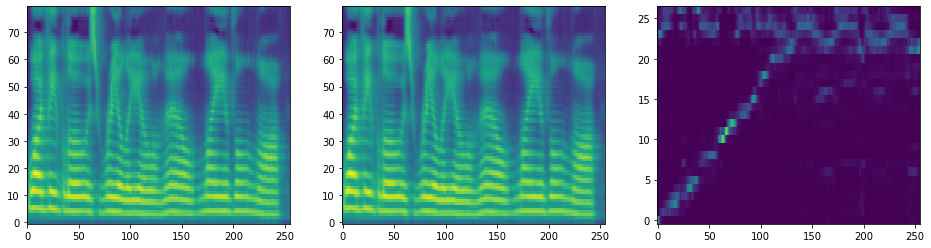

In [7]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

torch.Size([1, 27, 20])


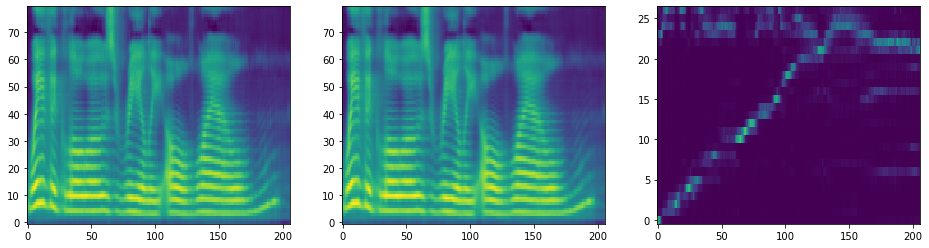

In [8]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

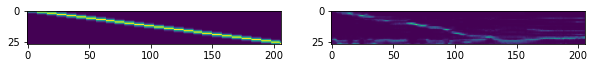

In [9]:
from loss_function import attention_mask
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(attention_mask(mel_outputs.size(2), sequence[0].size(0)).cpu().numpy().T)
axes[1].imshow(alignments.float().data.cpu().numpy()[0].T)


#### Synthesize audio from spectrogram using WaveGlow

In [10]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet.half(), sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [11]:
def generate(style):
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, style)
    plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
               alignments.float().data.cpu().numpy()[0].T))
    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet.half(), sigma=0.666)
    return audio

## Use same noise for every letter

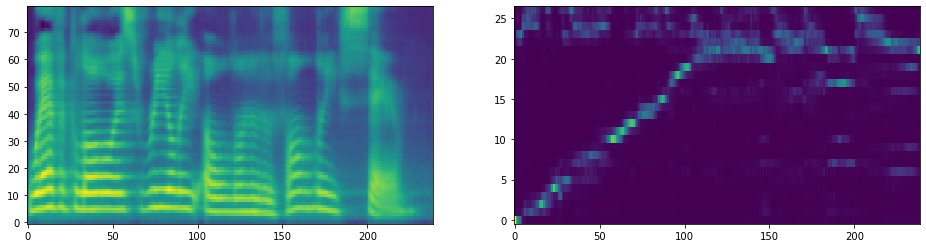

In [12]:
style = torch.zeros(1, 1, hparams.noise_size)
style = style.repeat_interleave(sequence.size(1), dim=1)
style[0, 0, :] = torch.ones(hparams.noise_size) * 0.6
audio = generate(style.cuda())
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

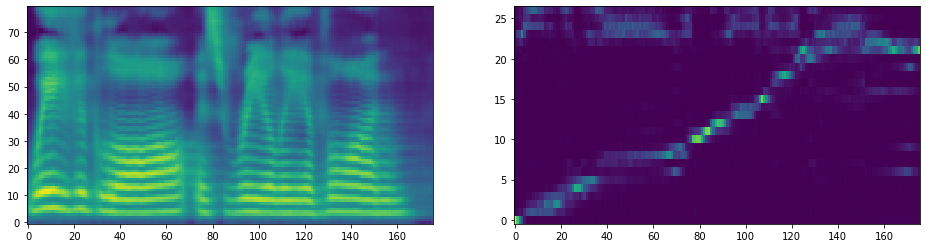

In [13]:
style[0, 0, :] = torch.ones(hparams.noise_size) * 0.2
audio = generate(style.cuda())
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

## Use different noise for each 

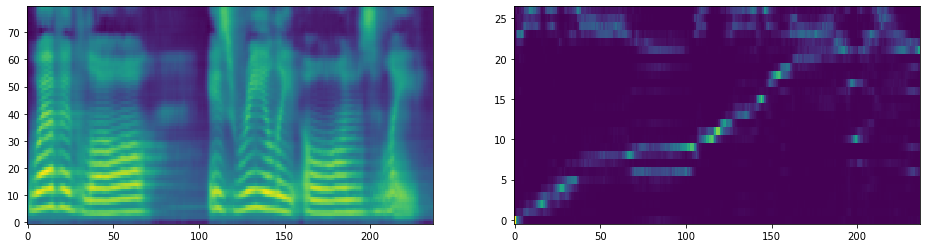

In [14]:
style = torch.rand(1, sequence.size(1), hparams.noise_size)
audio = generate(style.cuda())
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

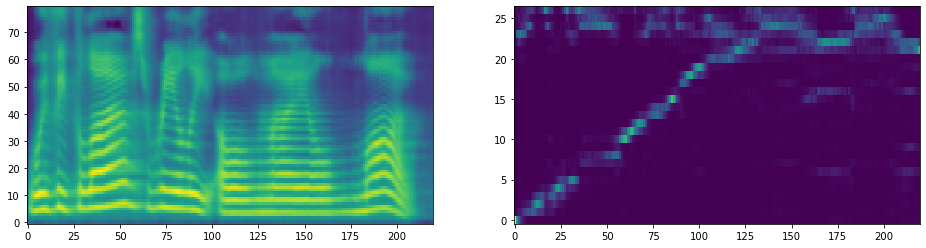

In [15]:
style[0, :10, :] = torch.ones(hparams.noise_size)
audio = generate(style.cuda())
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
style[0, :10, :] = torch.ones(hparams.noise_size) * 0.3
audio = generate(style.cuda())
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)